In [1]:
# Install (pip install pycddlib )
#pip install pycddlib

In [2]:
import cdd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import itertools
from dataclasses import dataclass, field
from typing import *
from abc import ABC, abstractmethod
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def save_weights(weights_list, biases_list, fname='weights_and_biases'):
    weights_and_biases_dict = {f'weights_{i}': weights for i, weights in enumerate(weights_list)}
    weights_and_biases_dict.update({f'biases_{i}': biases for i, biases in enumerate(biases_list)})
    weights_and_biases_dict.update({'number_layers': len(weights_list)})

    np.savez(f'{fname}.npz', **weights_and_biases_dict)

def load_weights(fname='weights_and_biases'):
    loaded = np.load(f'{fname}.npz')
    number_layers = loaded['number_layers']
    weights_list = [loaded[f'weights_{i}'] for i in range(0, number_layers)]
    biases_list = [loaded[f'biases_{i}'] for i in range(0, number_layers)]
    return weights_list, biases_list

def save_data(test_x, test_y, fname='data'):
    data_dict = {'test_x': test_x, 'test_y': test_y}
    np.savez(f'{fname}.npz', **data_dict)

def load_data(fname='data'):
    loaded = np.load(f'{fname}.npz')
    return loaded['test_x'], loaded['test_y']

In [4]:

def compute_dimension(vertices):
    # Convert the vertices to a numpy array
    vertices_array = np.array(vertices)
    
    # Compute the rank of the matrix of vertices
    rank = np.linalg.matrix_rank(vertices_array)

    return rank


vertices = [[0, 0, 0], [1, 1, 0], [2, 2, 0]]
print(compute_dimension(vertices)) 

vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 1]]
print(compute_dimension(vertices))  

1
2


In [5]:
def vertices_to_equations(vertices):
    # first column in v_matrix is 1 to inducate vertices rather than rays
    v_matrix = np.hstack((np.ones((vertices.shape[0],1)), vertices))
    cdd_v_matrix = cdd.Matrix(np.array(v_matrix))
    vpoly = cdd.Polyhedron(cdd_v_matrix)
    equations = vpoly.get_inequalities()
    return equations

def merge_equations(equations_x, equations_y):
    return np.vstack((equations_x, equations_y))

def equations_to_vertices(equations):
    mat1 = cdd.Matrix(equations, number_type = 'fraction')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)

    gen = poly1.get_generators()

    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    float_type = cdd.NumberTypeable('float')
    matrix = np.matrix([[float_type.make_number(gen[i][j]) for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned vertices (not rays)
    if not np.all(matrix[:,0] == 1):
        #import pdb; pdb.set_trace()
        #assert False
        # for some reason there is a ray. Possibly a rounding error? Ignore (treat as no solution)
        print(f"Warning; ray found in matrix {matrix}")
        # keep region for now (TODO: figure out what to do)

    # return just the vertices (not whether they are rays or not)
    return matrix[:,1:]

def intersection(vertices_x, vertices_y):
    equations_x = vertices_to_equations(vertices_x)
    equations_y = vertices_to_equations(vertices_y)
    equations_z = merge_equations(equations_x, equations_y)
    vertices_z = equations_to_vertices(equations_z)
    
    if vertices_z is None:
        return None

    # if edges(vertices_z) are not linearly independent, then return None (n-dimensioinal volume = 0)
    input_dims = vertices_z.shape[1] # number of coordinates in vertices is number of input dimensions
    if compute_dimension(vertices_z) < input_dims:
        # discard degenerate regions (points, lines etc. in higher dimensional space)
        return None
    
    return vertices_z

def avg_output(A, B):
    # function f is output within decison boundary A
    A_f = A.matrix_A
    B_f = A.vector_B
    # function g is output within decision boundary B
    A_g = B.matrix_A
    B_g = B.vector_B
    # output for region f is A_f * x + B_f
    # output for region g is A_g * x + B_g
    # return equation for region h (A_h * x + B_h) which is the average of f and g
    
    A_h = (A_f +A_g)/2
    B_h = (B_f +B_g)/2

    return A_h, B_h

def diff_output(A, B):
    # function f is output within decison boundary A
    A_f = A.matrix_A
    B_f = A.vector_B
    # function g is output within decision boundary B
    A_g = B.matrix_A
    B_g = B.vector_B
    # output for region f is A_f * x + B_f
    # output for region g is A_g * x + B_g
    # return equation for region h (A_h * x + B_h) which is the average of f and g
    
    A_h = (A_f - A_g)
    B_h = (B_f - B_g)

    return A_h, B_h

def volume_weighted_output(A, B):
    # function f is output within decison boundary A
    A_f = A.matrix_A
    B_f = A.vector_B
    vertices_f = A.vertices
    # function g is output within decision boundary B
    A_g = B.matrix_A
    B_g = B.vector_B
    vertices_g = B.vertices

    # output for region f is A_f * x + B_f
    # output for region g is A_g * x + B_g
    # return equation for region h (A_h * x + B_h) which is the average of f and g


    # Compute the Convex Hull of the vertices
    
    # Set flag Q12 to prevent the following:
    #
    # QH6271 qhull topology error (qh_check_dupridge): wide merge (824686947162.7x wider) due to dupridge between f3466 and f3563 (vertex dist 0.00039), merge dist 0.041, while processing p75
    # - Allow error with option 'Q12'
    # ...
    # A wide merge error has occurred.  Qhull has produced a wide facet due to facet merges and vertex merges.
    # This usually occurs when the input is nearly degenerate and substantial merging has occurred.
    # See http://www.qhull.org/html/qh-impre.htm#limit

    hull_f = ConvexHull(vertices_f, qhull_options = 'Q12')
    # The volume of the convex polytope is stored in the 'volume' attribute of the ConvexHull object
    volume_f = hull_f.volume
    hull_g = ConvexHull(vertices_g, qhull_options = 'Q12')
    volume_g = hull_g.volume

    weight_f = volume_f/(volume_f + volume_g) # depends on volume (scalar)
    weight_g = volume_g/(volume_f + volume_g)

    A_h = A_f * weight_f + A_g * weight_g
    B_h = B_f * weight_f + B_g * weight_g


    return A_h, B_h

In [6]:
example_region = np.matrix(
    [[ 0 , 0],
     [ 0,  1],
     [ 1,  0],
     [ 1,  1]])
example_region

matrix([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]])

In [7]:
#Given a polytope to check if the point is inside the polytope or outside, 
#we do a small check  inspired for mathematical analysis
#We take a small neighbourhood given a point in the $n$ dimensional space. For 2 dimensional polytopes the nbd is a
#square the side length $10^{-6}$. For 3 dimensional polytopes it's a cube of side length $10^{-6}$ and so on. 






In [8]:
def small_neighbourhood(input_point):
    #radius = 10**-6 # small value
    radius = 10**-3 # small value
    vertices = []
    input_dimensions = input_point.shape[0]
    for dim in range(input_dimensions):
        vertex1 = np.copy(input_point)
        vertex1[dim] -= radius
        vertices.append(vertex1)
        vertex2 = np.copy(input_point)
        vertex2[dim] += radius
        vertices.append(vertex2)
    return np.matrix(vertices)

In [9]:
example_point = np.array([0.5 , 0.5])
example_point2 = np.array([1.5 , 1.5])

In [10]:
small_neighbourhood(np.array([0.5,0.5,0.5]))

matrix([[0.499, 0.5  , 0.5  ],
        [0.501, 0.5  , 0.5  ],
        [0.5  , 0.499, 0.5  ],
        [0.5  , 0.501, 0.5  ],
        [0.5  , 0.5  , 0.499],
        [0.5  , 0.5  , 0.501]])

In [11]:
small_neighbourhood(np.array([0.5,0.5]))

matrix([[0.499, 0.5  ],
        [0.501, 0.5  ],
        [0.5  , 0.499],
        [0.5  , 0.501]])

In [12]:
print(intersection(example_region, small_neighbourhood(example_point)))

[[0.499 0.5  ]
 [0.5   0.499]
 [0.501 0.5  ]
 [0.5   0.501]]


In [13]:
print(intersection(example_region, small_neighbourhood(example_point2)))

None


In [14]:
@dataclass
class DecisionBoundary(ABC):
    label: str
    
    @abstractmethod
    def intersection(self, Y):
        raise NotImplementedEror()
        
@dataclass
class DecisionSpace:
    boundaries: List[DecisionBoundary]

@dataclass
class DecisionBoundaryNN(DecisionBoundary):
    # y = A * x + B
    matrix_A: np.ndarray # A
    vector_B: np.ndarray # B
    vertices: np.ndarray # a numpy matrix of vertices defining the region     
    # number of items of each class in the region
    # density: List[int]
    
    def intersection(self, Y, merge_fn=avg_output):
        X = self
        vertices_x = X.vertices
        vertices_y = Y.vertices
        vertices_z = intersection(vertices_x, vertices_y)
        
        if vertices_z is None:
            return None
        
        label_z = X.label + "," + Y.label
        A_z, B_z = merge_fn(X, Y)
        return DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)

@dataclass
class DecisionSpaceNN(DecisionSpace):
    pass





In [15]:
def in_boundary(boundary, input_vector):
    # return true if input_vector falls in boundary
    return intersection(boundary.vertices, small_neighbourhood(input_vector)) is not None
    
def find_boundary(boundaries, input_vector):
    for boundary in boundaries:
        if in_boundary(boundary, input_vector):
            return boundary
    # no boundary found (TODO figure out what to do!)

def get_output(decision_space, input_vector):
    # find decision boundary corresponding to input
    boundaries = decision_space.boundaries
    boundary = find_boundary(boundaries, input_vector)
    return get_boundary_output(boundary, input_vector)

def get_boundary_output(boundary, input_vector):
    # compute output for selected decision boundary
    A = boundary.matrix_A
    B = boundary.vector_B
    output_vector = A @ input_vector.T + B
    
    return output_vector[:,0].T

# 2D

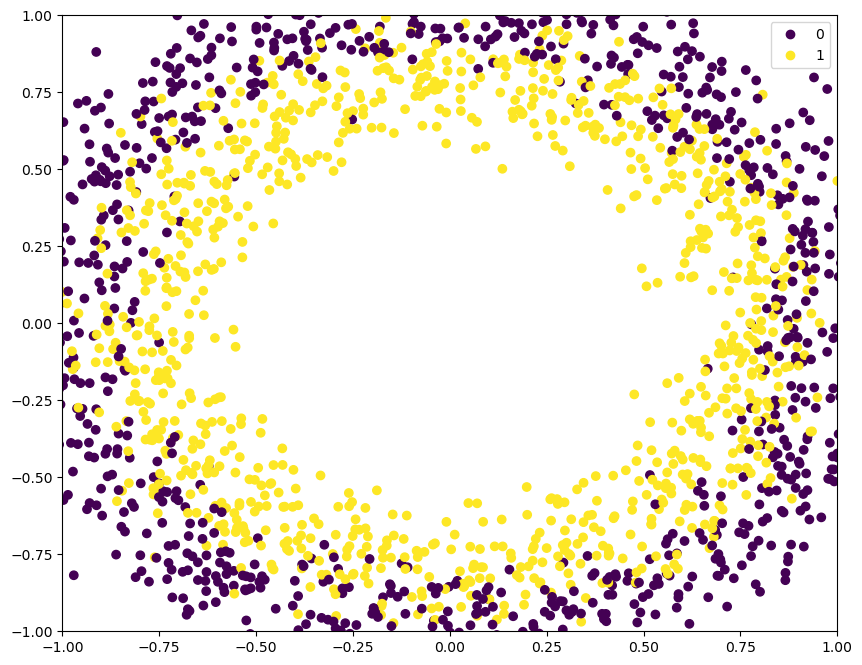

In [16]:
random_state = 0

x, y = make_circles(n_samples=2000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

plt.figure(figsize=(10,8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.legend(*scatter.legend_elements(), loc="upper right")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [17]:
from sklearn.neural_network import MLPClassifier
mlp1 = MLPClassifier(hidden_layer_sizes=[12], max_iter=10000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=1234, 
                    learning_rate_init=0.001)
mlp1.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[12], max_iter=10000,
              n_iter_no_change=100, random_state=1234, validation_fraction=0.2)

In [18]:
mlp1.score(test_x, test_y)


0.825

In [19]:
from sklearn.neural_network import MLPClassifier
mlp2 = MLPClassifier(hidden_layer_sizes=[12], max_iter=10000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=1235, 
                    learning_rate_init=0.001)
mlp2.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[12], max_iter=10000,
              n_iter_no_change=100, random_state=1235, validation_fraction=0.2)

In [20]:
mlp2.score(test_x, test_y)


0.855

# 3D

In [21]:
# Importing necessary libraries
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

# Loading the Iris dataset
iris = load_iris()
X = iris.data
Y = iris.target

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Creating a DataFrame
df = pd.DataFrame(X_scaled, columns=iris.feature_names)
df['species'] = Y

# Creating an interactive version of the plot using Plotly
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal length (cm)', color='species')
fig.show()

In [22]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [23]:
# Importing necessary libraries
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Loading the Iris dataset
iris = load_iris()
X = iris.data[:, :3]  # we only take the first three features.
Y = iris.target

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Creating a Multi-layer Perceptron classifier
clf = MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42)

# Training the MLP classifier
clf.fit(X_train, y_train)

# Predicting the test set results
y_pred = clf.predict(X_test)

# Showing the classification report
print(classification_report(y_test, y_pred, target_names=iris.target_names))


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



/Users/anupamchaudhauri/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



In [24]:
clf.coefs_

[array([[ 0.45799416,  0.60666886, -0.3837783 ,  0.20343058],
        [-1.40892887, -0.29871337,  0.15346897, -0.46660415],
        [ 0.85541443,  0.1695168 , -1.81304229,  2.11935373]]),
 array([[-1.15158292,  0.77567292,  0.01904687],
        [-0.54227863,  0.01965567, -0.49861632],
        [ 0.83888307, -1.44124621, -1.27713659],
        [-0.45331296, -1.96662119,  1.21208481]])]

In [25]:
clf.intercepts_

[array([ 1.56682064, -0.75000781,  0.12972501, -0.19187742]),
 array([ 0.09619564, -0.22260902, -0.41782931])]

In [26]:
def get_coefs_and_intercepts(eg="3D"):
    if eg == "aletheia":
        #Aletheia weights
        coefs = [np.array([[ 1.26330575,  0.81106997,  2.28835997,  0.66100558],
                [ 0.37596265,  0.36973942, -0.85882211,  2.02183899]]),
         np.array([[ 0.87355974],
                [ 1.89058246],
                [-1.89513973],
                [-2.56049663]])]
        intercepts = [np.array([ 1.47921924,  0.93827836, -0.02134388, -0.4247285 ]),
         np.array([-0.66509044])]
    elif eg == "2D_1":
        # 2D weights (concentric circles)
        coefs = mlp1.coefs_
        intercepts = mlp1.intercepts_
    elif eg == "2D_2":
        # 2D weights (concentric circles)
        coefs = mlp2.coefs_
        intercepts = mlp2.intercepts_
    elif eg == "3D":
        # 3D weights
        coefs = clf.coefs_
        intercepts = clf.intercepts_
    elif eg == "MNIST_1":
        coefs, intercepts = load_weights('weights_and_biases1')
    elif eg == "MNIST_2":
        coefs, intercepts = load_weights('weights_and_biases2')
    elif eg == "MNIST_3":
        coefs, intercepts = load_weights('weights_and_biases3')
    else:
        raise Exception()
    
    return coefs, intercepts

coefs1, intercepts1 = get_coefs_and_intercepts("2D_1")
coefs2, intercepts2 = get_coefs_and_intercepts("2D_2")

# coefs1, intercepts1 = get_coefs_and_intercepts("MNIST_1")
# coefs2, intercepts2 = get_coefs_and_intercepts("MNIST_2")

# coefs1, intercepts1 = get_coefs_and_intercepts("MNIST_3")
# coefs2, intercepts2 = get_coefs_and_intercepts("MNIST_3")
# test_x, test_y = load_data('data3')

#coefs1, intercepts1 = get_coefs_and_intercepts("3D")
#coefs2, intercepts2 = get_coefs_and_intercepts("3D")
#test_x, test_y = X_test, y_test

# coefs1, intercepts1 = load_weights("weights_and_biases4")
# coefs2, intercepts2 = load_weights("weights_and_biases4")
# test_x, test_y = load_data('data4')

# coefs1, intercepts1 = load_weights("weights_and_biases_higgs")
# coefs2, intercepts2 = load_weights("weights_and_biases_higgs2")
# test_x, test_y = load_data('data_higgs')


In [27]:
#test_x.shape, test_y.shape

In [28]:
#test_x[0].shape

In [29]:
coefs1, intercepts1

([array([[-0.6819536 ,  0.15170264,  0.79787967,  0.37748644,  1.14019017,
          -0.72428009, -0.54438381,  0.25547438,  0.6330705 ,  1.49131505,
          -0.23167307,  0.01723993],
         [ 0.82458821,  0.11913321, -1.03671398, -0.08170606,  0.0102017 ,
          -1.10840595,  1.02173025,  1.1875278 , -0.30282805,  0.70152709,
          -1.09923904, -0.35856448]]),
  array([[-0.49116892],
         [ 1.03150613],
         [-1.4145967 ],
         [ 1.02236295],
         [-1.56141418],
         [-0.96182837],
         [-0.86636773],
         [-0.69499272],
         [ 0.54026044],
         [-1.27674179],
         [-0.90977427],
         [ 0.50908871]])],
 [array([ 0.10660515,  0.61877715, -0.1513361 ,  0.77752749, -0.19290144,
         -0.13066247,  0.06634651, -0.27071685,  0.91004348, -0.39807279,
          0.05219368,  0.76835303]),
  array([0.11563174])])

In [30]:
coefs2, intercepts2

([array([[ 1.66962471,  0.39143055,  0.01510772,  0.41798475,  0.03068936,
           1.3510692 , -1.99073586, -1.47726681, -1.74528993,  1.82730497,
           0.77476648,  0.30076991],
         [-1.05410288,  0.33163833,  0.83848864, -0.21437519,  0.50023224,
          -1.85044009, -0.0077416 ,  1.61526064, -0.93114916,  1.56895438,
           2.06972545,  0.25321141]]),
  array([[-0.62557435],
         [ 0.23967625],
         [ 1.03244958],
         [ 0.15629061],
         [ 1.02693898],
         [-1.97327044],
         [-1.78234652],
         [-2.45283295],
         [-1.39762264],
         [-1.54995771],
         [-2.36815209],
         [ 1.15560951]])],
 [array([-0.07774122, -0.59819915,  1.4666531 , -0.58053491,  1.35798307,
         -0.32959304, -0.32740627, -0.86527068, -0.40082755, -0.2029603 ,
         -0.33525805,  1.15793026]),
  array([1.00675541])])

In [31]:
def vector_mask_to_matrix(v):
    return np.eye(v.shape[0]) * v

In [32]:
def find_activation_region_layer_l(coefs, intercepts, pattern_l, pattern_previous,
                                   A_previous, B_previous, layer,
                                   constraints_A, constraints_B):
    # pattern is a column vector, 1 => active, 0 => inactive
    # convert to                  1 => active, -1 => inactive (to make it easier to flip equations)
    inequality_dir = pattern_l * 2 - 1 # 1 -> 1, 0 -> -1
    #print("inequality_dir", inequality_dir)
    
    #constraints_A, constraints_b = get_constraints_layer1(pattern_layer1, coefs, intercepts)
    
    W_l = coefs[layer].transpose()
    
    # Convert pattern previous to matrix
    pattern_previous_matrix = vector_mask_to_matrix(pattern_previous)
    
    A_l = (W_l @ pattern_previous_matrix @ A_previous)
    
    # need to negate A_l as solves -Ax + b > 0
    A = np.vstack((-A_l * inequality_dir, constraints_A))
    
    b_l = intercepts[layer][:,np.newaxis]
    B_l = (W_l @ pattern_previous_matrix @ B_previous + b_l)

    b = np.vstack((B_l * inequality_dir, constraints_B))
    
    #import pdb; pdb.set_trace()
    
    # compute H = [b - A] to represent system of inequalities,
    # and use pycddlib to solve and find vertices of resultant polytope that satisfies inequalities
        
    H = np.hstack((b,-A))
    

    mat1 = cdd.Matrix(H, number_type = 'fraction')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)
    #print("H matrix", poly1) # debug
    
    gen = poly1.get_generators()
    #print(gen)
    #print("V matrix", gen) # debug

    
    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    float_type = cdd.NumberTypeable('float')
    matrix = np.matrix([[float_type.make_number(gen[i][j]) for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned vertices (not rays)
    assert np.all(matrix[:,0] == 1)

    # return just the vertices (not whether they are rays or not)
    # also returns linear equation for region (A_l * x + B_l) and full set of constraints (A, b)
    return matrix[:,1:], A_l, B_l, A, b, pattern_l

In [33]:
def generate_regions(coefs, intercepts, layer):
    """
    Generates regions for the given layer
    coefs - weight coefs for NN generated by scikit-learn
    intercepts - biases for NN generated by scikit-learn
    layer - number of layers
    """

    def get_num_inputs():
        return coefs[0].shape[0]
        
    def get_neurons(l):
        return intercepts[l].shape[0]
    
    matricies = []

    # todo filter to just the activation patterns that have non-zero area
    perms_layers = []
    for l in range(layer):
        neurons_l = get_neurons(l)
        # todo: add one neuron at at time to avoid considering exponential number of permutations
        perms_l = list(itertools.product([0,1], repeat=neurons_l))
        perms_layers.append(perms_l)

    
    prev_results = []
    
    # 1st layer is special
    # assuming n layers
    for perm1 in perms_layers[0]:
        pattern_layer1 = np.array(perm1)[:,np.newaxis]

        # additional terms in A for constraints on x1, x2, ...:
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        # and also:
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        #..
        num_inputs = get_num_inputs()
        constraints_A_layer1 = np.vstack(
            (np.eye(num_inputs),
             -np.eye(num_inputs))
        )
        
        # additional terms in b for constraints on x1 and x2
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        constraints_b_layer1 = np.ones((2 * num_inputs,1))
        
        neurons_layer1 = get_num_inputs()

        # layer 1 is index 0 in coefs
        # treat (non-existant) previous layer as all active neurons with identity
        result_1 = find_activation_region_layer_l(
                                    coefs, intercepts, pattern_layer1, np.ones(num_inputs),
                                    np.eye(num_inputs), np.zeros(num_inputs)[:,np.newaxis], 0,
                                    constraints_A_layer1, constraints_b_layer1)

        if result_1 is None:
            #print(f"could not find region for {perm1}")
            continue

        prev_results.append((result_1, [perm1]))
    
    # breadth-first iteration over all pattern results in each layer
    for l in range(1, layer):
        results = []
        
        for prev_result, prev_perms in prev_results:
            matrix_prev, A_lprev, B_lprev, A_prev, b_prev, pattern_layer_prev = prev_result
            
            for perm in perms_layers[l]:
                pattern_layer = np.array(perm)[:,np.newaxis]

                # layer 2 is index 1 in coefs
                result_l = find_activation_region_layer_l(
                                            coefs, intercepts, pattern_layer, pattern_layer_prev,
                                            A_lprev, B_lprev, l,
                                            A_prev, b_prev)

                if result_l is None:
                    #print(f"could not find region for {perm}")
                    continue
                
                results.append((result_l, prev_perms + [perm]))
        
        prev_results = results
    
    #matricies = []
    decision_boundaries = []
    
    for prev_result, prev_perms in prev_results:
        matrix, A_l, B_l, A_2, b_2, pattern = prev_result
        #matricies.append((matrix, str(prev_perms)))
        boundary = DecisionBoundaryNN(str(prev_perms), A_l, B_l, matrix)
        decision_boundaries.append(boundary)
    
    #return matricies
    return DecisionSpaceNN(decision_boundaries)


In [34]:
def relu(x):
    return np.maximum(0, x)

def find_pattern(coefs, intercepts, layer, z_previous):
    """
    z_previous - output of the previous layer (or input vector if is the first layer)
    Finds the activation pattern for a particular point
    """
    W_l = coefs[layer].transpose()
    b_l = intercepts[layer][:,np.newaxis]
    x_l = W_l @ z_previous + b_l
    z_l = relu(x_l)
    print(x_l) # debug
    pattern = tuple(np.where(x_l[:,0] > 0, 1, 0))
    return pattern, z_l
    

In [35]:
def find_region(coefs, intercepts, layer, input_point):
    """
    Finds activation region for the given input point
    coefs - weight coefs for NN generated by scikit-learn
    intercepts - biases for NN generated by scikit-learn
    layer - number of layers
    input_point - input point to lookup activation region for
    """

    def get_num_inputs():
        return coefs[0].shape[0]
        
    def get_neurons(l):
        return intercepts[l].shape[0]
    
    matricies = []
    
    perms_layers = []
    z_previous = input_point[:, np.newaxis] # transform to column vector
    for l in range(layer):
        neurons_l = get_neurons(l)
        # just generate the pattern in each layer for the input_point
        pattern, z_previous = find_pattern(coefs, intercepts, l, z_previous)
        #perms_layers.append([pattern[:,0]])
        perms_layers.append([pattern])
        #import pdb; pdb.set_trace()
    
    print(perms_layers)
    
    # rest of this function is identical to generate_regions
    prev_results = []
    
    # 1st layer is special
    # assuming n layers
    for perm1 in perms_layers[0]:
        pattern_layer1 = np.array(perm1)[:,np.newaxis]

        # additional terms in A for constraints on x1, x2, ...:
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        # and also:
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        #..
        num_inputs = get_num_inputs()
        constraints_A_layer1 = np.vstack(
            (np.eye(num_inputs),
             -np.eye(num_inputs))
        )
        
        # additional terms in b for constraints on x1 and x2
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        constraints_b_layer1 = np.ones((2 * num_inputs,1))
        
        neurons_layer1 = get_num_inputs()

        # layer 1 is index 0 in coefs
        # treat (non-existant) previous layer as all active neurons with identity
        result_1 = find_activation_region_layer_l(
                                    coefs, intercepts, pattern_layer1, np.ones(num_inputs),
                                    np.eye(num_inputs), np.zeros(num_inputs)[:,np.newaxis], 0,
                                    constraints_A_layer1, constraints_b_layer1)

        if result_1 is None:
            print(f"could not find region for {perm1}")
            continue

        prev_results.append((result_1, [perm1]))
    
    # breadth-first iteration over all pattern results in each layer
    for l in range(1, layer):
        results = []
        
        for prev_result, prev_perms in prev_results:
            matrix_prev, A_lprev, B_lprev, A_prev, b_prev, pattern_layer_prev = prev_result
            
            for perm in perms_layers[l]:
                pattern_layer = np.array(perm)[:,np.newaxis]

                # layer 2 is index 1 in coefs
                result_l = find_activation_region_layer_l(
                                            coefs, intercepts, pattern_layer, pattern_layer_prev,
                                            A_lprev, B_lprev, l,
                                            A_prev, b_prev)

                if result_l is None:
                    print(f"could not find region for {perm}")
                    continue
                
                results.append((result_l, prev_perms + [perm]))
        
        prev_results = results
    
    #matricies = []
    decision_boundaries = []
    
    for prev_result, prev_perms in prev_results:
        matrix, A_l, B_l, A_2, b_2, pattern = prev_result
        #matricies.append((matrix, str(prev_perms)))
        boundary = DecisionBoundaryNN(str(prev_perms), A_l, B_l, matrix)
        decision_boundaries.append(boundary)
    
    #return matricies
    return DecisionSpaceNN(decision_boundaries)


In [36]:
def plot_decision_space_nn(decision_space : DecisionSpaceNN, output_dim=0, vis_out=True, shading='gouraud',
                          vmin=-7, vmax=7):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Define a color map that linearly transitions from black to white
    cmap = LinearSegmentedColormap.from_list('black_to_white', ['black', 'white'], N=256)


    for boundary in decision_space.boundaries: # plot just first boundary
        vertices = np.array(boundary.vertices) # use np.array not np.matrix
        label =  boundary.label
        
        # compute the convex hull of the points
        hull = ConvexHull(vertices)

        # extract the x and y coordinates of the convex hull
        x = vertices[hull.vertices, 0]
        y = vertices[hull.vertices, 1]
        
        # output = A * input + B
        A = boundary.matrix_A
        B = boundary.vector_B
        
        if vis_out:
            input_vect = np.vstack((x.T, y.T))
            #import pdb; pdb.set_trace()
            output = A @ input_vect + B
        
            # Allow to select dimension (for now plot output dimension 0)
            output = output[output_dim]
            #print(max(output), min(output))

        # create a triangulation
        #import pdb; pdb.set_trace()
        #triang = tri.Triangulation(x.flatten(), y.flatten())

        # plot the triangles with colors
        #plt.tripcolor(triang, output, cmap=cm.viridis, alpha=0.3, edgecolors='k')
        #import pdb; pdb.set_trace()
        if vis_out:
            # shade triangle proportional to output
            plt.tripcolor(x.flatten(), y.flatten(), output, norm=norm, cmap=cmap, shading=shading)
        else:
            plt.fill(x, y, alpha=0.3, label=label, edgecolor='k')
            #plt.plot(x, y, 'ko')
            #plt.scatter(x, y, c=output, norm=norm, cmap=cmap)
                
        # If working, should always be 2 (same as input)
        # print(compute_dimension(vertices))

        #plt.plot(x, y, 'ko')

        # plot and fill the polygon
        #plt.fill(x, y, color=cm.viridis(output), alpha=0.3, label=label)

    # set the axis labels and title
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title('Polygon Plot')

    # show the plot with a colorbar
    if vis_out:
        plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_82334/4252639403.py:65: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


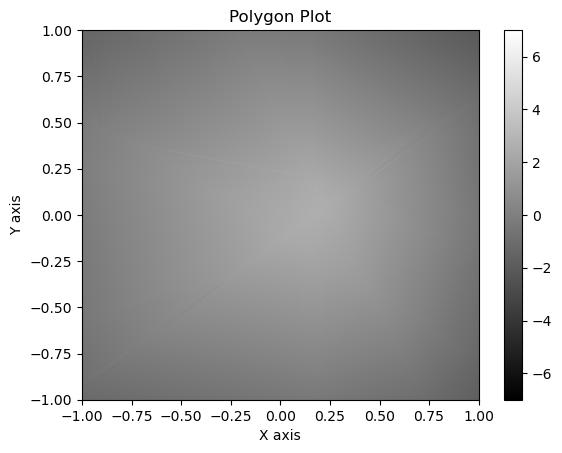

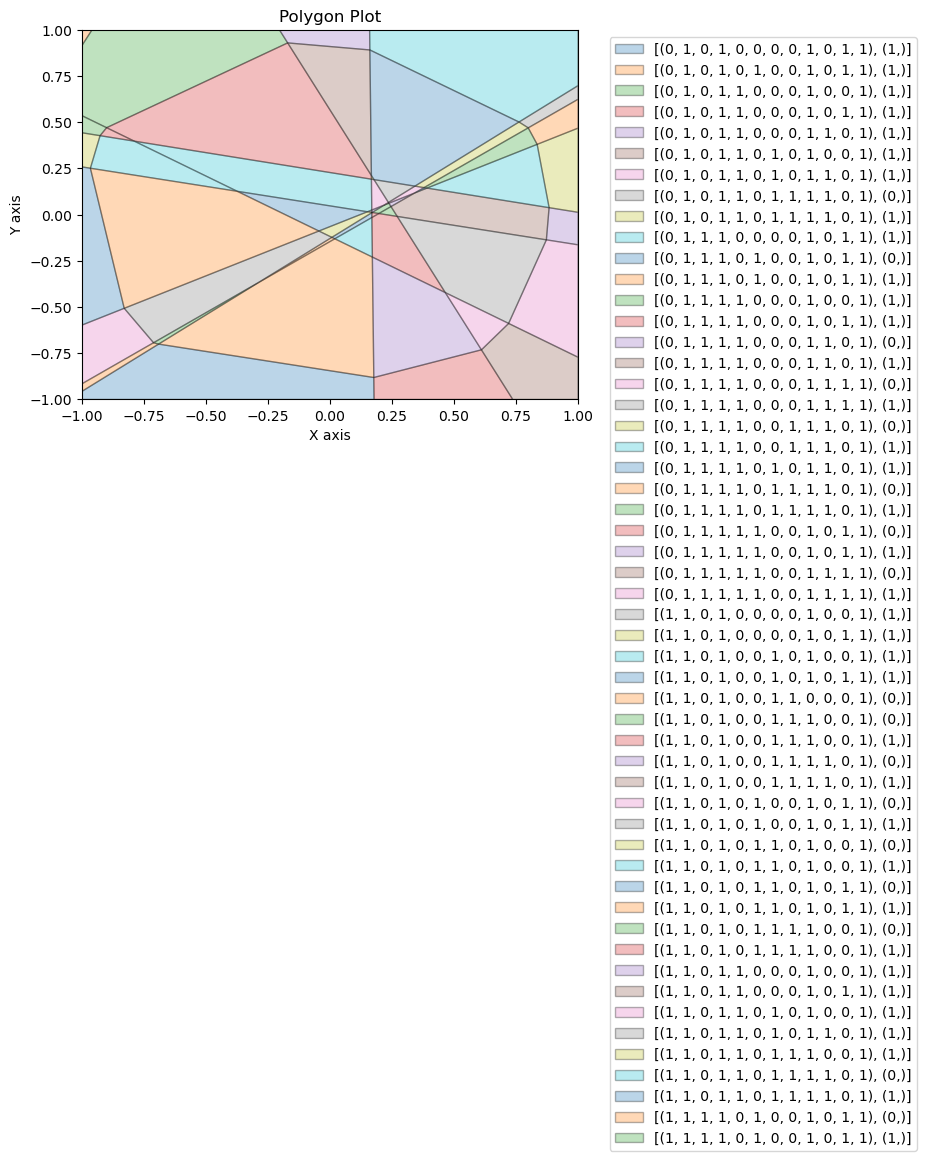

In [37]:
decision_space_1 = generate_regions(coefs1, intercepts1, 2)
plot_decision_space_nn(decision_space_1,0)
plot_decision_space_nn(decision_space_1,0,False)

In [38]:
# point = np.array([0.5,0.6])

#point = test_x[0]
#point

In [39]:
# out = ""
# for point in np.linspace(-1, 1, 100):
#     try:
#         region = find_region(coefs1, intercepts1, 2, np.array([point])).boundaries[0].label
#     except Exception:
#         region = "not found"

#     out += f"{point:.1f} {region}\n"

# print(out)

In [40]:
#decision_space_1_region = find_region(coefs1, intercepts1, 1, point)

In [41]:
#plot_decision_space_nn(decision_space_1_region,0,False)

In [42]:
# point = np.array([0, 0,  0,  0,
#        0, 0, 0,  0,
#         0,  0,  0, 0,
#        0])
# decision_space_1_region = find_region(coefs1, intercepts1, 1, point)

/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_82334/4252639403.py:65: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


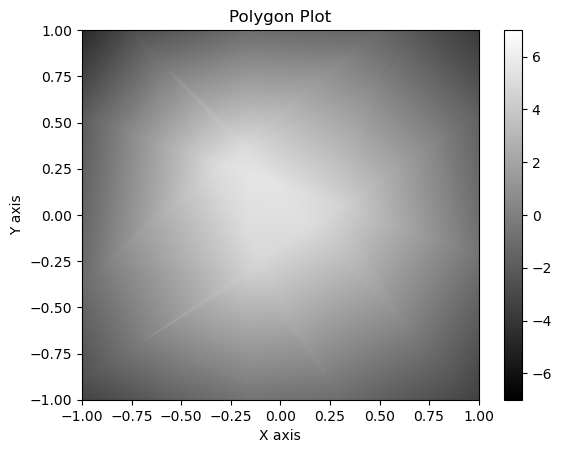

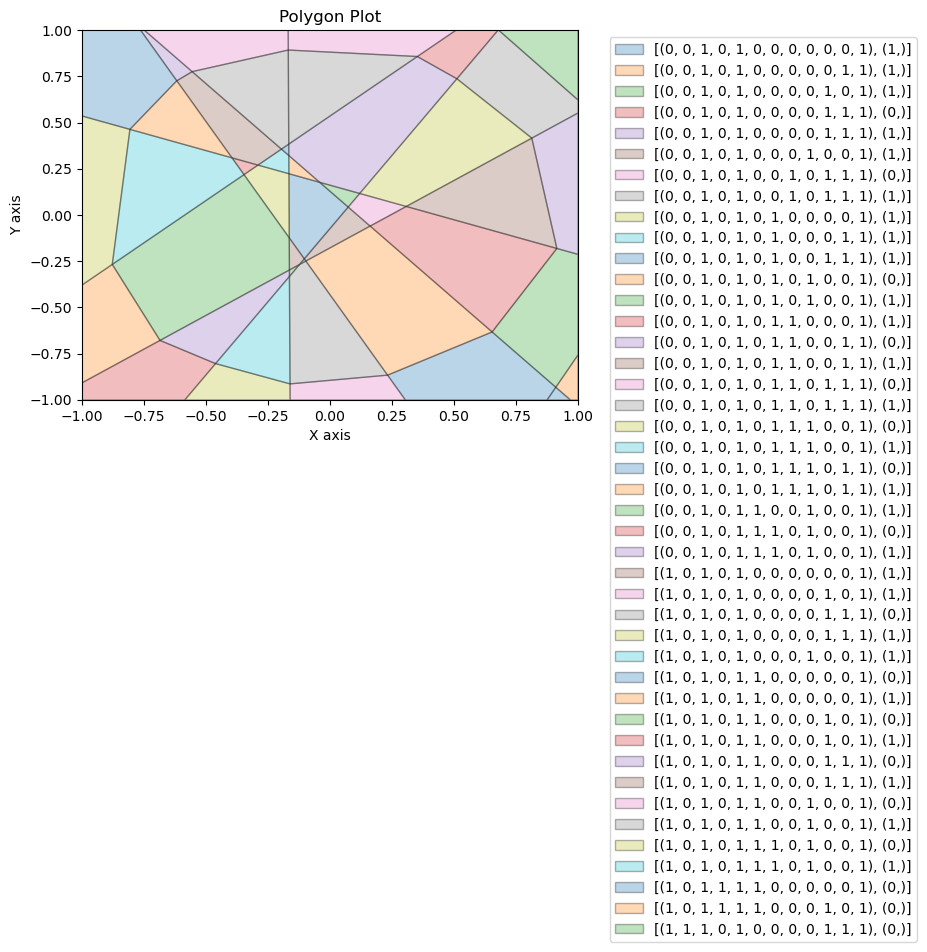

In [43]:
decision_space_2 = generate_regions(coefs2, intercepts2, 2)
plot_decision_space_nn(decision_space_2,0)
plot_decision_space_nn(decision_space_2,0,False)

In [44]:
##Intersection 

In [45]:
# sanity test: intersection with self should give same result (but may list points in a different order)
# intersection(decision_space_1.boundaries[0].vertices, decision_space_1.boundaries[0].vertices)

In [46]:
# decision_space_1.boundaries[0].vertices

In [47]:
def merge_decision_space(X, Y, merge_fn=avg_output):
    Z = []
    for boundary_x in X.boundaries:
        for boundary_y in Y.boundaries:
            intersection = boundary_x.intersection(boundary_y, merge_fn)
            if intersection is not None:
                Z.append(intersection)
    return DecisionSpace(Z)


In [48]:
# decision_space_3 = merge_decision_space(decision_space_1, decision_space_2)
# plot_decision_space_nn(decision_space_3,0)
# plot_decision_space_nn(decision_space_3,0,False)

In [49]:
# decision_space_4 = merge_decision_space(decision_space_1, decision_space_2, merge_fn=diff_output)
# plot_decision_space_nn(decision_space_4,0,vmin=-1, vmax=1)

In [50]:
# len(decision_space_1.boundaries)

In [51]:
# len(decision_space_2.boundaries)

In [52]:
# len(decision_space_3.boundaries)

In [53]:
# print(get_output(decision_space_1, np.array([0,0])))
# print(get_output(decision_space_2, np.array([0,0])))
# print(get_output(decision_space_3, np.array([0,0])))

In [54]:
# print(get_output(decision_space_1, np.array([0.6,0.8])))
# print(get_output(decision_space_2, np.array([0.6,0.8])))
# print(get_output(decision_space_4, np.array([0.6,0.8])))

In [55]:
from sklearn.metrics import accuracy_score

def classify(decision_space, points):
    results = []
    for point in points:
        #print(f"Debug: classifying point {point}")
        y = get_output(decision_space, point)
        results.extend(y)
    return np.array(results)


def classify_on_fly(coefs, intercepts, layers, points):
    results = []
    for point in points:
        print(point)
        decision_space = find_region(coefs, intercepts, layers, point)
        #print(f"Debug: classifying point {point}")
        y = get_boundary_output(decision_space.boundaries[0], point)
        results.append(y) # y can be multi-class
    return np.array(results)

#debug_points = [] #DEBUG

def classify_on_fly_merged(coefs1, intercepts1, layers1, coefs2, intercepts2, layers2, merge_fn, points):
    results = []
    for point in points:
        print(point)
        #debug_points.append(point)
        decision_space1 = find_region(coefs1, intercepts1, layers1, point)
        decision_space2 = find_region(coefs2, intercepts2, layers2, point)
        # this sometimes results in rays / no region (todo: figure out why)
        # decision_space3 = merge_decision_space(decision_space1, decision_space2, merge_fn)
        
        X = decision_space1.boundaries[0] # only one boundary for find_region
        Y = decision_space2.boundaries[0]
        vertices_z = small_neighbourhood(point) # could be anything that contains point
        label_z = X.label + "," + Y.label
        A_z, B_z = merge_fn(X, Y)
        #decision_space3 = DecisionSpaceNN([DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)])
        decision_boundary3 = DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)

        #print(f"Debug: classifying point {point}")
        #y = get_output(decision_space3, point)
        y = get_boundary_output(decision_boundary3, point)
        #results.extend(y)
        results.append(y) # y can be multi-class
    return np.array(results)

# drop points that are outside boundary
bounded_test_x = test_x[
    (test_x > -1).all(axis=1) & (test_x < 1).all(axis=1)
]
bounded_test_y = test_y[
    (test_x > -1).all(axis=1) & (test_x < 1).all(axis=1)
]

In [56]:
# just test on a subset of the data
# bounded_test_x = bounded_test_x[:5000]
# bounded_test_y = bounded_test_y[:5000]

In [57]:
# pred_y1 = classify(decision_space_1, bounded_test_x)
# pred_y1 = np.where(pred_y1 > 0, 1, 0)

# accuracy_score(bounded_test_y, pred_y1)

In [58]:
# pred_y2 = classify(decision_space_2, bounded_test_x)
# pred_y2 = np.where(pred_y2 > 0, 1, 0)

# accuracy_score(bounded_test_y, pred_y2)

In [59]:
# pred_y3 = classify(decision_space_3, bounded_test_x)
# pred_y3 = np.where(pred_y3 > 0, 1, 0)

# accuracy_score(bounded_test_y, pred_y3)

In [60]:
# bounded_test_x[0]

In [61]:
# mlp2.predict_proba([bounded_test_x[0]])

In [62]:
# classify(decision_space_2, [bounded_test_x[0]])

In [63]:
# from scipy.special import expit
# expit(classify(decision_space_2, [bounded_test_x[0]]))

In [64]:
# decision_space_5 = merge_decision_space(decision_space_1, decision_space_2, merge_fn=volume_weighted_output)
# plot_decision_space_nn(decision_space_5,0)
# plot_decision_space_nn(decision_space_5,0,False)

In [65]:
# pred_y5 = classify(decision_space_5, bounded_test_x)
# pred_y5 = np.where(pred_y5 > 0, 1, 0)

# accuracy_score(bounded_test_y, pred_y5)

In [66]:
# need to include final layer (softmax) as the weights between the relu layer and the softmax affect output
# todo: include softmax layer when computing output, but not as part of activation region/pattern

# pred_y6 = classify_on_fly_merged(
#     coefs1, intercepts1, 3, coefs2, intercepts2, 3,
#     volume_weighted_output, bounded_test_x)

In [67]:
# point = np.array([0.89768757, -0.66129109,  0.72308376,  0.0286497,  -0.80049216, -0.36732962])
# decision_space1 = find_region(coefs1, intercepts1, 3, point)
# decision_space1.boundaries[0].vertices

In [68]:
# point = np.array([-0.35042147, -0.93489531, -0.36387789,  0.81477701, -0.78641961, -0.12329875])
# #point = np.array([-0.4, -0.9, -0.3,  0.8, -0.7, -0.1])
# decision_space1 = find_region(coefs1, intercepts1, 3, point)
# decision_space1

In [69]:
pred_y6.shape

NameError: name 'pred_y6' is not defined

In [ ]:
pred_y6[0]

In [ ]:
import scipy
scipy.special.softmax(pred_y6[0])

In [ ]:
pred_y6.shape

In [ ]:
#np.argmax(pred_y6, axis=1)
np.where(pred_y6[:,0] > 0, 1, 0)

In [ ]:
#pred_y6 = np.where(pred_y6 > 0, 1, 0)
# for single class:
pred_y6 = np.where(pred_y6[:,0] > 0, 1, 0)
best_bounded_test_y = bounded_test_y

# for multiclass:
#best_pred_y6 = np.argmax(pred_y6, axis=1)
#best_bounded_test_y = np.argmax(bounded_test_y, axis=1)

accuracy_score(best_bounded_test_y, pred_y6)

In [ ]:
pred_y6

In [ ]:
best_bounded_test_y

In [ ]:
list(bounded_test_y)[1000:1020]

In [ ]:
bounded_test_y.shape

In [ ]:
bounded_test_x.shape

In [ ]:
pred_y6.shape

In [ ]:
pred_y7 = classify_on_fly(
    coefs1, intercepts1, 3, bounded_test_x)

In [ ]:
best_pred_y7 = np.where(pred_y7[:,0] > 0, 1, 0)
best_bounded_test_y = bounded_test_y

accuracy_score(best_bounded_test_y, best_pred_y7)

In [ ]:
bounded_test_x.shape

In [ ]:
point = np.array([0.72156864, 0.,         0.00392157, 0.89411765])
small_neighbourhood(point)

In [ ]:
decision_space1 = find_region(coefs1, intercepts1, 2, point)
decision_space2 = find_region(coefs2, intercepts2, 2, point)
# this sometimes results in rays / no region (todo: figure out why)
# decision_space3 = merge_decision_space(decision_space1, decision_space2, merge_fn)

X = decision_space1.boundaries[0] # only one boundary for find_region
Y = decision_space2.boundaries[0]
vertices_z = small_neighbourhood(point) # could be anything that contains point
label_z = X.label + "," + Y.label
A_z, B_z = volume_weighted_output(X, Y)
decision_space3 = DecisionSpaceNN([DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)])

#print(f"Debug: classifying point {point}")
y = get_output(decision_space3, point)



In [ ]:
p2

In [ ]:
point = p2

decision_space1 = find_region(coefs1, intercepts1, 2, point)
decision_space2 = find_region(coefs2, intercepts2, 2, point)
# this sometimes results in rays / no region (todo: figure out why)
# decision_space3 = merge_decision_space(decision_space1, decision_space2, merge_fn)

X = decision_space1.boundaries[0] # only one boundary for find_region
Y = decision_space2.boundaries[0]
vertices_z = small_neighbourhood(point) # could be anything that contains point
label_z = X.label + "," + Y.label
A_z, B_z = volume_weighted_output(X, Y)
decision_space3 = DecisionSpaceNN([DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)])

#print(f"Debug: classifying point {point}")
y = get_output(decision_space3, point)


In [ ]:
decision_space3.boundaries[0].vertices

In [ ]:
point

In [ ]:
small_neighbourhood(point)

In [ ]:
in_boundary(decision_space3.boundaries[0], point)

In [ ]:
get_output(decision_space3, point)

In [ ]:
import pandas as pd;
pd.DataFrame({'y5': pred_y5, 'y2': pred_y2, 'test_y': bounded_test_y}).to_csv('comparison.csv')